In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import itertools
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score


from datasets.datasets import get_10x_73k, get_australian_dataloader, get_wine_dataloader, get_rings_dataloader, get_iris_dataloader, get_synthetic_dataloader, get_MNIST_dataloader, get_MNIST_subset_dataloader, get_Pendigits_dataloader, get_even_or_odd_Pendigits_dataloader, get_FashionMNIST_dataloader, get_FashionMNIST_5_dataloader
from Generator_Encoder.encoder import Conv_Encoder, FC_Encoder

## Mnist

In [2]:
Tensor = torch.cuda.FloatTensor if False else torch.FloatTensor

latent_dim = 10
n_clusters = 10

batch_size = 30000
dataloader = get_MNIST_dataloader(batch_size=batch_size)
#dataloader = get_MNIST_subset_dataloader(batch_size=batch_size)

encoder = Conv_Encoder(latent_dim, n_clusters)
encoder.load_state_dict(torch.load("./encoder.pth"))
#encoder.load_state_dict(torch.load("./Trained_Models/encoder.pth"))

FileNotFoundError: [Errno 2] No such file or directory: './encoder.pth'

## Fashion-MNIST

In [ ]:
Tensor = torch.cuda.FloatTensor if False else torch.FloatTensor
latent_dim = 10
n_clusters = 5

batch_size = 60000
#dataloader = get_FashionMNIST_dataloader(batch_size=batch_size)
dataloader = get_FashionMNIST_5_dataloader(batch_size=batch_size)
encoder = Conv_Encoder(latent_dim, n_clusters)
#encoder.load_state_dict(torch.load("./Trained_Models/Fashion-MNIST/encoder.pth"))
encoder.load_state_dict(torch.load("./Trained_Models/Fashion-MNIST_5/encoder.pth"))

## Pendigits

In [7]:
Tensor = torch.cuda.FloatTensor if False else torch.FloatTensor

latent_dim = 5
n_clusters = 10

batch_size = 7494
batch_size_even = 5542
batch_size_odd = batch_size - batch_size_even
dataloader, data_shape = get_Pendigits_dataloader(batch_size=batch_size)
#dataloader, data_shape = get_even_or_odd_Pendigits_dataloader(batch_size=batch_size_even, even=True)
#dataloader, data_shape = get_even_or_odd_Pendigits_dataloader(batch_size=batch_size_odd, even=False)

encoder = FC_Encoder(latent_dim, n_clusters, data_shape)
encoder.load_state_dict(torch.load("./encoder_Pendigits_ACC_84_NMI_76.pth"))

<All keys matched successfully>

## 10x_73k

In [2]:
Tensor = torch.cuda.FloatTensor if False else torch.FloatTensor

latent_dim = 10
n_clusters = 8

batch_size = 10000
dataloader, data_shape = get_10x_73k(batch_size=batch_size, data_points=batch_size)

encoder = FC_Encoder(latent_dim, n_clusters, data_shape)
encoder.load_state_dict(torch.load("./encoder_10x_37k_Acc_88_NMI_75.pth"))

<All keys matched successfully>

## Synthetic

In [2]:
Tensor = torch.cuda.FloatTensor if False else torch.FloatTensor
latent_dim = 2
n_clusters = 4

batch_size = 800

dataloader, data_shape = get_synthetic_dataloader(batch_size=batch_size)
encoder = FC_Encoder(latent_dim, n_clusters, data_shape)
encoder.load_state_dict(torch.load("./encoder_550.pth"))

<All keys matched successfully>

## Iris

In [18]:
Tensor = torch.cuda.FloatTensor if False else torch.FloatTensor
latent_dim = 2
n_clusters = 3

batch_size = 150
dataloader, data_shape = get_iris_dataloader(batch_size=batch_size)
encoder = FC_Encoder(latent_dim, n_clusters, data_shape)
encoder.load_state_dict(torch.load("./encoder_200.pth"))

FileNotFoundError: [Errno 2] No such file or directory: './encoder_200.pth'

## Two Rings

In [3]:
Tensor = torch.cuda.FloatTensor if False else torch.FloatTensor
latent_dim = 1
n_clusters = 2

batch_size = 1000
dataloader, data_shape = get_rings_dataloader(batch_size=batch_size)
encoder = FC_Encoder(latent_dim, n_clusters, data_shape)
encoder.load_state_dict(torch.load("./encoder_2700.pth"))

<All keys matched successfully>

## Wine

In [2]:
Tensor = torch.cuda.FloatTensor if False else torch.FloatTensor
latent_dim = 2
n_clusters = 3

batch_size = 178
dataloader, data_shape = get_wine_dataloader(batch_size=batch_size)
encoder = FC_Encoder(latent_dim, n_clusters, data_shape)
encoder.load_state_dict(torch.load("./Wine.pth"))

<All keys matched successfully>

## Austarlian

In [2]:
Tensor = torch.cuda.FloatTensor if False else torch.FloatTensor
latent_dim = 5
n_clusters = 2

batch_size = 690
dataloader, data_shape = get_australian_dataloader(batch_size=batch_size)
encoder = FC_Encoder(latent_dim, n_clusters, data_shape)
encoder.load_state_dict(torch.load("./Austr.pth"))

<All keys matched successfully>

## Compute ACC and NMI

In [3]:
latent_data = np.zeros((batch_size, latent_dim + n_clusters))
all_labels = np.zeros((batch_size))

for batch_index, (real_data, labels) in enumerate(dataloader):
    real_data = Variable(real_data.type(Tensor), requires_grad=False)
    # Encode real images
    enc_zn, enc_zc, enc_zc_cluster_id = encoder(real_data)
    
    # Save latent_data and their labels
    lower = batch_index * batch_size 
    upper = (batch_index + 1) * batch_size
    np_enc_zn = enc_zn.cpu().detach().numpy()
    np_enc_zc = enc_zc.cpu().detach().numpy()
    np_labels = labels.cpu().detach().numpy()
    latent_data[lower:upper] = np.concatenate((np_enc_zn, np_enc_zc), axis=1)
    all_labels[lower:upper] = np_labels
    
    # Get the data clustering
    clustering = torch.argmax(enc_zc, dim=1)
    clustering = clustering.cpu().detach().numpy()
    
    # Find the cluster ids (labels)
    c_ids = np.unique(clustering)
    labels = labels.cpu().data.numpy()
    
    # Dictionary to transform cluster label to real label
    dict_clusters_to_labels = dict()
    
    # For every cluster find the most frequent data label
    for c_id in c_ids:
        indexes_of_cluster_i = np.where(c_id == clustering)
        elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
        true_label_index = np.argmax(frequency)
        true_label = elements[true_label_index]
        dict_clusters_to_labels[c_id] = true_label
        
    print(dict_clusters_to_labels)
    # Change the cluster labels to real labels
    for i, element in enumerate(clustering):
        clustering[i] = dict_clusters_to_labels[element]
    
    # Metrics
    accuracy = accuracy_score(labels, clustering)
    nmi = normalized_mutual_info_score(labels, clustering)
    print("Accuracy = %.2f, NMI = %.2f" % (accuracy, nmi))

{0: 1.0, 1: 0.0}
Accuracy = 0.67, NMI = 0.10


In [4]:
def compute_purity(y_pred, y_true):
        """
        Calculate the purity, a measurement of quality for the clustering 
        results.
        
        Each cluster is assigned to the class which is most frequent in the 
        cluster.  Using these classes, the percent accuracy is then calculated.
        
        Returns:
          A number between 0 and 1.  Poor clusterings have a purity close to 0 
          while a perfect clustering has a purity of 1.

        """

        # get the set of unique cluster ids
        clusters = set(y_pred)

        # find out what class is most frequent in each cluster
        cluster_classes = {}
        correct = 0
        for cluster in clusters:
            # get the indices of rows in this cluster
            indices = np.where(y_pred == cluster)[0]

            cluster_labels = y_true[indices]
            majority_label = np.argmax(np.bincount(cluster_labels))
            correct += np.sum(cluster_labels == majority_label)
        
        return float(correct) / len(y_pred)

In [6]:
#km = KMeans(n_clusters=n_clusters).fit(latent_data)
km = KMeans(n_clusters=n_clusters).fit(real_data)
labels_pred = km.labels_

all_labels = all_labels.astype("int")
purity = compute_purity(labels_pred, all_labels)
nmi = normalized_mutual_info_score(all_labels, labels_pred)
print("Purity = %.2f, NMI = %.2f" % (purity, nmi))

Purity = 0.86, NMI = 0.43


## TSNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 690 samples in 0.001s...
[t-SNE] Computed neighbors for 690 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 690 / 690
[t-SNE] Mean sigma: 0.029527
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.587170
[t-SNE] KL divergence after 500 iterations: 0.651650


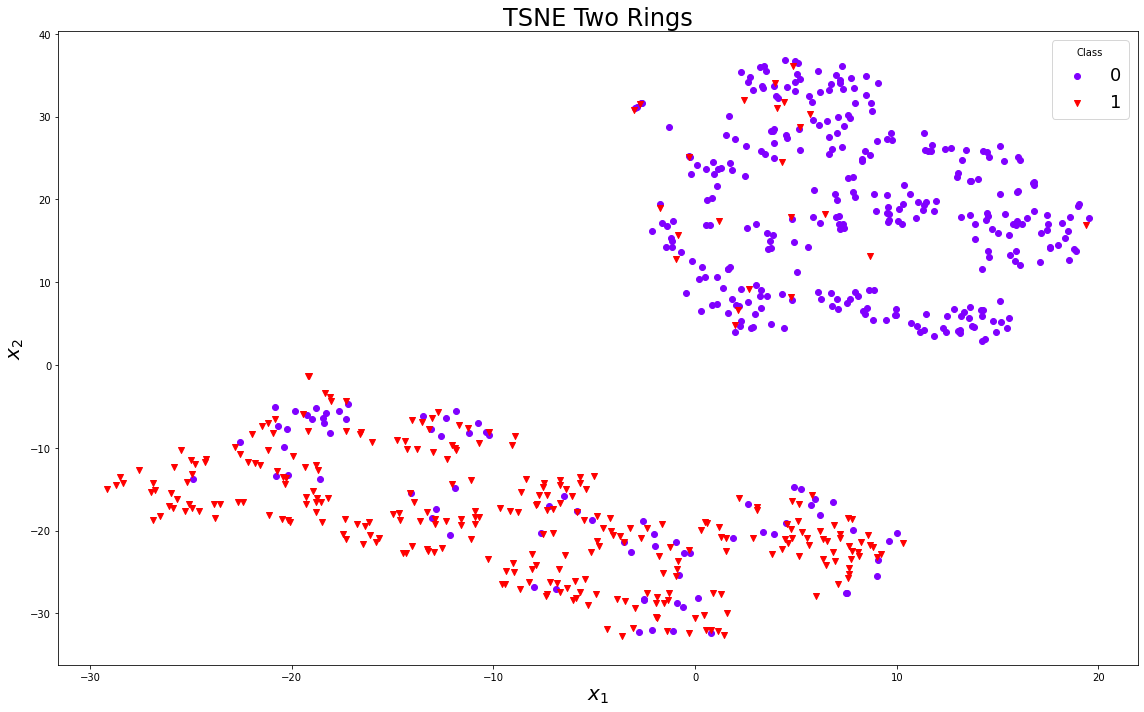

In [9]:
# Cluster with TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_enc = tsne.fit_transform(latent_data)
#tsne_enc = tsne.fit_transform(real_data)

# Color and marker for each true class
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
markers = matplotlib.markers.MarkerStyle.filled_markers

# Save TSNE figure to file
fig, ax = plt.subplots(figsize=(16, 10))
for iclass in range(0, n_clusters):
    # Get indices for each class
    idxs = all_labels==iclass
    # Scatter those points in tsne dims
    ax.scatter(tsne_enc[idxs, 0], tsne_enc[idxs, 1],
               marker=markers[iclass], c=colors[iclass].reshape(1,-1),
               edgecolor=None, label=r'$%i$'%iclass)
    
figname="TSNE Two Rings"
ax.set_title(figname, fontsize=24)
ax.set_xlabel("$x_{1}$", fontsize=20)
ax.set_ylabel("$x_{2}$", fontsize=20)
plt.legend(title="Class", loc='best', numpoints=1, fontsize=18)
plt.tight_layout()
plt.show()
#fig.savefig(figname, facecolor='w')

In [11]:
real_data.shape

torch.Size([690, 14])

In [12]:
latent_data.shape

(690, 7)